In [1]:
# IMPORTS #############################################################################################################################################

import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

In [34]:
# PARAMETERS ##########################################################################################################################################


# Size of the images
img_height, img_width = 96,96

# Parameters
num_classes         = 7     # ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
epochs_top_layers   = 5
epochs   = 100
batch_size          = 128
DROPOUT_RATE        = 0.2

In [3]:
# DATASETS ############################################################################################################################################

# Folder where logs and models are stored
folder = 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/logs/MOBILENET'

# Data paths
train_dataset	= 'C:/Users/skywalker/Desktop/Meriem_Taieb_Yasmine_mahdoui/facial_emotion_recognition/final_train_images'
eval_dataset 	= 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/validation'

In [35]:

# # DATA PREPARATION ####################################################################################################################################

#create an ImageDataGenerator and generate batches of data
def get_datagen(dataset, aug=False):
    if aug: #check if augmentation is enabled
        datagen = ImageDataGenerator(
                            rescale=1./255, #rescale the pixel values to [0,1]
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                            width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of the width
                            height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
                            zoom_range=0.1, # Randomly zoom into images by up to 10%
                            horizontal_flip=True) #randomly flip images horizontally
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(96, 96), 
            color_mode='rgb',
            shuffle = True, 
            class_mode='categorical',
            batch_size=batch_size) #size of the batch 

train_generator  = get_datagen(train_dataset, True)
dev_generator    = get_datagen(eval_dataset)

Found 31268 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [39]:
#MODEL ########################

base_model=MobileNetV2(
    include_top = False,
    weights     = 'imagenet',
    input_shape = (img_height, img_width, 3)
)

x=base_model.output
x = GlobalAveragePooling2D()(x)

# x = Dense(128, activation = 'relu')(x)
# x=Dense(64,activation = 'relu')(x)
# x=Dropout(DROPOUT_RATE)(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

# model.summary()

In [40]:
from sklearn.utils import class_weight
data=pd.read_csv('C:/Users/skywalker/Desktop/Meriem_Taieb_Yasmine_mahdoui/facial_emotion_recognition/fer2013/fer2013_eval.csv')
Y=data['emotion'].values
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y),y=Y)
class_weights=dict(enumerate(class_weights))
print('Class_ weights ', class_weights)

Class_ weights  {0: 1.0978892627714898, 1: 9.15561224489796, 2: 1.0336981566820276, 3: 0.5728651237031125, 4: 0.7851673594399475, 5: 1.2354561101549053, 6: 0.844669333960932}


In [41]:
# FULL NETWORK TRAINING ###############################################################################################################################

# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from ResNet-50


# Fine-tuning of all the layers
for layer in model.layers:
    layer.trainable = True

# We need to recompile the model for these modifications to take effect (we use SGD with nesterov momentum and a low learning rate)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       float >= 0. Learning rate
        # momentum: float >= 0. Parameter updates momentum
        # decay:    float >= 0. Learning rate decay over each update
        # nesterov: boolean. Whether to apply Nesterov momentum
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = Adam(learning_rate = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
tensorboard_all_layers = TensorBoard(
    log_dir         = folder + '/logs_all_layers',
    histogram_freq  = 0,
    write_graph     = True,
    write_images    = True)

# Reduce learning rate when a metric has stopped improving
	# monitor: 	Quantity to be monitored
	# factor: 	Factor by which the learning rate will be reduced. new_lr = lr * factor
	# patience:	Number of epochs with no improvement after which learning rate will be reduced
	# mode: 	One of {auto, min, max}
	# min_lr:	Lower bound on the learning rate
reduce_lr_plateau = ReduceLROnPlateau(
	monitor 	= 'val_accuracy',
	factor		= 0.5,
	patience	= 3,
	mode 		= 'auto',
	min_lr		= 1e-8)

# Stop training when a monitored quantity has stopped improving
	# monitor:		Quantity to be monitored
	# patience:		Number of epochs with no improvement after which training will be stopped
	# mode: 		One of {auto, min, max}
early_stop = EarlyStopping(
	monitor 	= 'val_accuracy',
	patience 	= 10,
	mode 		= 'auto')
	

# Save the model after every epoch
	# filepath:       String, path to save the model file
	# monitor:        Quantity to monitor {val_loss, val_acc}
	# save_best_only: If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
	# mode:           One of {auto, min, max}. If save_best_only = True, the decision to overwrite the current save file is made based on either
	#			      the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should
	#			      be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity
	# period:         Interval (number of epochs) between checkpoints

# We train our model again (this time fine-tuning all the resnet blocks)
model.fit(
    x           = train_generator,
    steps_per_epoch     = len(train_generator),  # samples_per_epoch / batch_size 
    epochs              = epochs,                        
    validation_data     = dev_generator,
    callbacks           = [tensorboard_all_layers, reduce_lr_plateau,early_stop],
	class_weight        = class_weights)

# SAVING ##############################################################################################################################################

# Saving the model in the workspace
model.save(folder + '/MobileNetV2.h5')
# # Save model.h5 on to google storage
# with file_io.FileIO('ResNet-50.h5', mode='rb') as input_f:
#     with file_io.FileIO(folder + '/ResNet-50.h5', mode='wb') as output_f:  # w+ : writing and reading
#         output_f.write(input_f.read())


Epoch 1/100
245/245 [==============================] - 146s 582ms/step - loss: 1.8424 - accuracy: 0.3614 - val_loss: 1.7897 - val_accuracy: 0.3767 - lr: 1.0000e-04
Epoch 2/100
245/245 [==============================] - 52s 213ms/step - loss: 1.3439 - accuracy: 0.5049 - val_loss: 1.5865 - val_accuracy: 0.4528 - lr: 1.0000e-04
Epoch 3/100
245/245 [==============================] - 53s 214ms/step - loss: 1.1542 - accuracy: 0.5661 - val_loss: 1.4291 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 4/100
245/245 [==============================] - 53s 215ms/step - loss: 1.0414 - accuracy: 0.6042 - val_loss: 1.4429 - val_accuracy: 0.4748 - lr: 1.0000e-04
Epoch 5/100
245/245 [==============================] - 53s 216ms/step - loss: 0.9617 - accuracy: 0.6294 - val_loss: 1.5247 - val_accuracy: 0.4567 - lr: 1.0000e-04
Epoch 6/100
245/245 [==============================] - 53s 216ms/step - loss: 0.8859 - accuracy: 0.6561 - val_loss: 1.3604 - val_accuracy: 0.5107 - lr: 1.0000e-04
Epoch 7/100
245/245 [

In [21]:
test_dataset='C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/test'
test_generator=get_datagen(test_dataset)

Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras.models import load_model
model=load_model("C:/Users/skywalker/Desktop/Meriem_Taieb_Yasmine_mahdoui/facial_emotion_recognition/logs/MOBILENET/MobileNetV2.h5")
print('\n# Evaluate on dev data')
results_dev = model.evaluate(dev_generator)
print('dev loss, dev acc:', results_dev)

print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator)
print('test loss, test acc:', results_test)

# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()


# Evaluate on dev data
57/57 [==============================] - 18s 267ms/step - loss: 1.4136 - accuracy: 0.6565
dev loss, dev acc: [1.4136182069778442, 0.6564502716064453]

# Evaluate on test data
113/113 [==============================] - 5s 44ms/step - loss: 1.3578 - accuracy: 0.6644
test loss, test acc: [1.3577580451965332, 0.6643912196159363]


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

113/113 [==============================] - 4s 29ms/step


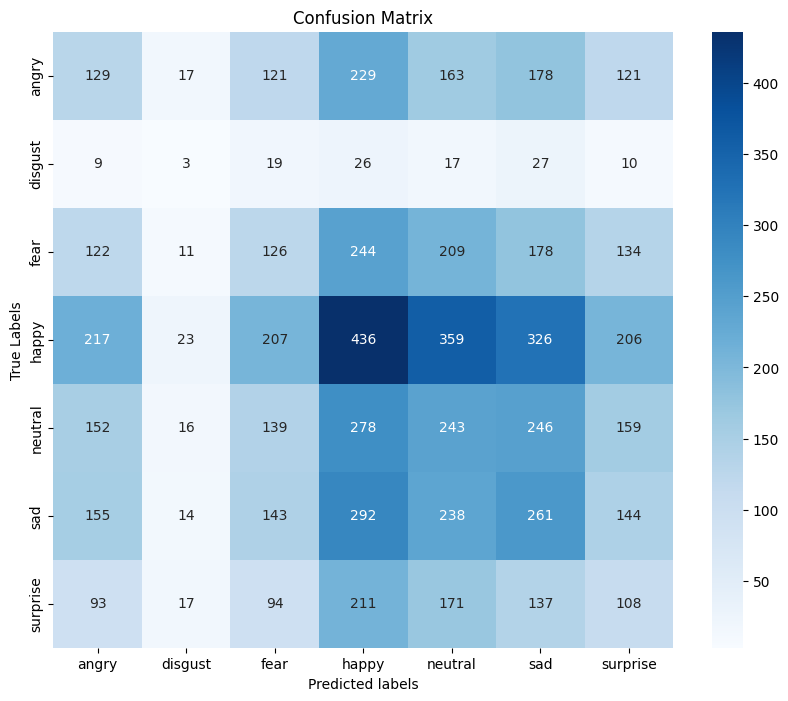

In [23]:
#get the true labels
true_labels=test_generator.classes
predicted_labels=model.predict(test_generator).argmax(axis=-1)

#confusion matrix
cm=confusion_matrix(true_labels,predicted_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")

plt.show()

Confusion matrix (Accuracy)


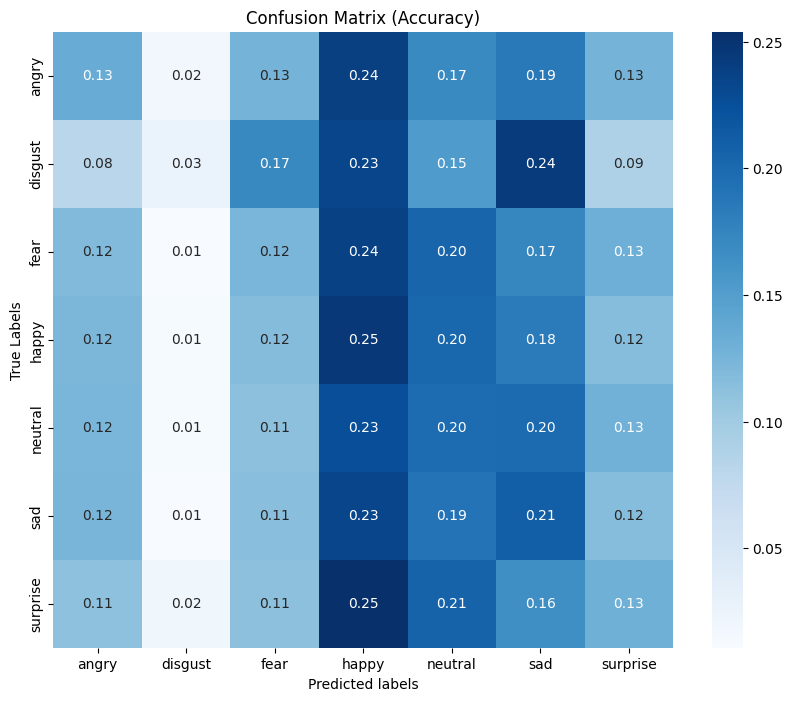

In [24]:
total_samples=np.sum(cm)

cm_acc=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
print('Confusion matrix (Accuracy)')

plt.figure(figsize=(10,8))
sns.heatmap(cm_acc,annot=True,fmt=".2f",cmap='Blues',xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix (Accuracy)")

plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predicted_labels))

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


              precision    recall  f1-score   support

           0       0.15      0.13      0.14       958
           1       0.03      0.03      0.03       111
           2       0.15      0.12      0.13      1024
           3       0.25      0.25      0.25      1774
           4       0.17      0.20      0.18      1233
           5       0.19      0.21      0.20      1247
           6       0.12      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178

Precision: 0.15260136331014892
Recall: 0.1524068881315233
F1 Score: 0.15210653096562138


In [46]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

# Compile your model with custom metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', precision, recall, f1_score])

# Evaluate the model on the test dataset
loss, accuracy, precision, recall, f1_score = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1_score)

113/113 [==============================] - 4s 30ms/step - loss: 1.4690 - accuracy: 0.6595 - precision: 0.6774 - recall: 0.6417 - f1_score: 0.6589
Test Loss: 1.469020962715149
Test Accuracy: 0.6595152020454407
Test Precision: 0.6773560047149658
Test Recall: 0.6417312026023865
Test F1 Score: 0.6588736176490784
